In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.style.use('ggplot')
import random

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeBinomialPmf, Beta, MakeMixture
import thinkplot

import scipy.stats as stats

from itertools import product
from operator import truediv

% matplotlib inline

import gdal
import gdalconst

In [2]:
class BilFile(object):

    def __init__(self, bil_file):
        self.bil_file = bil_file
        self.hdr_file = bil_file.split('.')[0]+'.hdr'

    def get_array(self, mask=None):
        self.nodatavalue, self.data = None, None
        gdal.GetDriverByName('EHdr').Register()
        img = gdal.Open(self.bil_file, gdalconst.GA_ReadOnly)
        band = img.GetRasterBand(1)
        self.nodatavalue = band.GetNoDataValue()
        self.ncol = img.RasterXSize
        self.nrow = img.RasterYSize
        geotransform = img.GetGeoTransform()
        self.originX = geotransform[0]
        self.originY = geotransform[3]
        self.pixelWidth = geotransform[1]
        self.pixelHeight = geotransform[5]
        self.data = band.ReadAsArray()
        self.data = np.ma.masked_where(self.data==self.nodatavalue, self.data)
        if mask is not None:
            self.data = np.ma.masked_where(mask==True, self.data)
        return self.nodatavalue, self.data

In [3]:
def ReadBilFile(bil):
    gdal.GetDriverByName('EHdr').Register()
    img = gdal.Open(bil, gdalconst.GA_ReadOnly)
    band = img.GetRasterBand(1)
    data = band.ReadAsArray()
    return data

def GetMonthlyPrismData():
    months = ['january','february','march','april','may','june','july','august','september','october','november','december']
    month_ns = ['01','02','03','04','05','06','07','08','09','10','11','12']
    res = dict()
    for i in range(12):
        f = BilFile(r'/alexandria/weather/prism-data/' + month_ns[i] + '-' + months[i] + '/PRISM_ppt_30yr_normal_800mM2_' + month_ns[i] + '_bil.bil')
        a = f.get_array()
        data = a[1].clip(0)
        res[months[i]] = pd.DataFrame(data)

    return pd.Panel(res)

In [43]:
import psycopg2
from shapely.geometry import mapping, shape, Point
import json

from math import radians, cos, sin, asin, sqrt
# http://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine(c1, c2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, c1 + c2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [47]:
class RoadGeolocation:
    def __init__(self, db_name='mass'):
        self.conn = psycopg2.connect(database=db_name, user='wolf')
        self.curs = self.conn.cursor()
        
        self.cache = dict()
        
    def close():
        self.conn.close()
        
    def query_road_name(self, name):
        """ query GIS for all roads with a given name (exact) and caches the results """
        if name in self.cache:
            return self.cache[name]

        # hope nobody tries to SQL inject this code...
        self.curs.execute("""\
        SELECT osm_id, ST_AsGeoJSON(way) \
        FROM planet_osm_line \
        WHERE name = '{}';\
        """.format(name))

        roads_with_name = self.curs.fetchall()
        
        self.cache[name] = [(r[0], shape(json.loads(r[1]))) for r in roads_with_name]
        
        return self.cache[name]
    
    def distance_to_road(self, point, road_geom):
        """ returns the closest km distance between a long-lat point and a road """
        
        length_along_road_closest = road_geom.project(point)
        point_closest = road_geom.interpolate(length_along_road_closest)

        return haversine(point.coords[0], point_closest.coords[0])
    
    def closest_road_with_name(self, point, name):
        roads = self.query_road_name(name)
        
        # km
        distances = [self.distance_to_road(point, r[1]) for r in roads]
        
        return min(distances)
    
    def likelihood_to_see_road(self, data, hypo):
        """computes probability of data given hypo
        
        data: road name
        
        hypo: x,y location in longitude,latitude
        """
        
        
        distance_km = self.closest_road_with_name(Point(*hypo), data)
        
        # extreme approximation, given more time we would use
        # https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk
        # to approximate the *actual* random walk of a person looking around
        return 1.0 / distance_km


In [48]:
road_geolocator = RoadGeolocation()

In [50]:
print(road_geolocator.closest_road_with_name(Point(-72.444278, 42.490497), 'Olin Way'))

print(road_geolocator.closest_road_with_name(Point(-71.263940, 42.293553), 'Olin Way'))

99.2701679319
0.101488945626


In [52]:
print(road_geolocator.closest_road_with_name(Point(-72.444278, 42.490497), 'Massachusetts Avenue'))

13.2780523252


In [57]:
%%timeit

print(road_geolocator.closest_road_with_name(Point(-72.44, 32.0), 'Massachusetts Avenue'))

1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.06627001
1050.0

In [61]:
%%timeit

print(road_geolocator.closest_road_with_name(Point(-72.44, 42.0), 'Oak Avenue'))

27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.1121052573
27.112

In [51]:
%%timeit

print(road_geolocator.closest_road_with_name(Point(-71.263940, 42.293553), 'Olin Way'))

0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.101488945626
0.10148894

In [13]:
class Geolocation(Suite, Joint):
    
    def __init__(self,xs,ys):
        """Makes a joint suite of location parameters x and y

        Enumerates all combinations of x, y

        xs: possible longitudinal (east-west) coordinates
        ys: possible latitudinal (north-south) coordinates
        """
        
        months = ['january','february','march','april','may','june','july','august','september','october','november','december']
        monthly_hours = [744,672,744,720,744,720,744,744,720,744,720,744]
        rain_data = GetMonthlyPrismData()
        #print('data retrieved')
        self.rain_percents = dict()
        for i,item in enumerate(rain_data.items):
            self.rain_percents[months[i]] = rain_data[months[i]] / (monthly_hours[i] * 3)
            #print(str(months[i]) + ' percentage calculated')
        
        locations = product(xs,ys) # (3105, 7025)
        
        self.road_helper = RoadGeolocation('mass')
        
        Suite.__init__(self, locations)
    
    def Likelihood(self, data, hypo):
        """computes probability of data given hypo
        
        data: tuple of (data type, observation):
                ("road name", road name)
                ("rain", ({"raining","not raining"},month))
        
        hypo: x,y location in longitude,latitude
        """
        data_type, observation = data
        x, y = hypo
        
        if data_type == "rain":
            rain_state, month = observation
            if rain_state == "raining":
                like = self.rain_percents[month][x][y]
                
            elif rain_state == "not raining":
                like = 1 - self.rain_percents[month][x][y]
                
            else:
                raise ValueError("is it raining or not raining?")
                
            return like
        
        elif data_type == "road name":
            road_name = observation
            like = self.road_helper.likelihood_to_see_road(road_name, hypo)
            return like
        
        else:
            raise ValueError("Invalid data type")

In [14]:
suite = Geolocation(range(7025),range(3105))

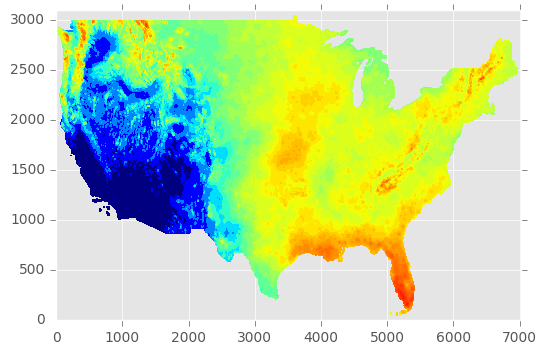

In [25]:
plt.contourf(suite.rain_percents['june'],origin='image',levels = np.linspace(0, .2, 40),cmap=plt.cm.jet,norm = LogNorm())

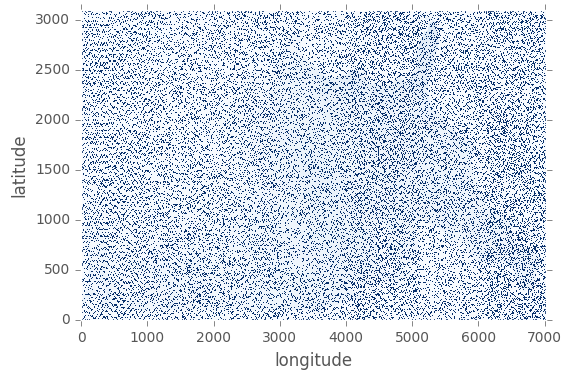

In [11]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='longitude',
                ylabel='latitude',
                axis=[0, 7025, 0, 3105])

In [12]:
suite.Update(("rain",("raining","june")))

0.0049382749359162363

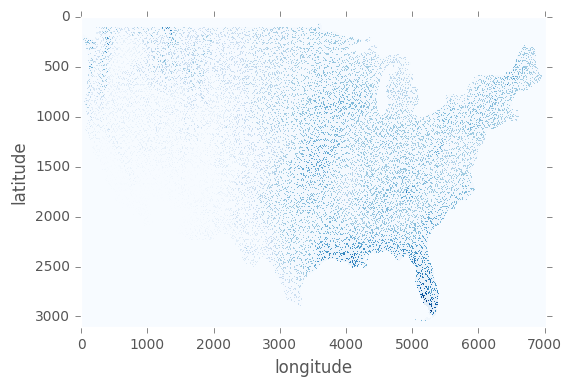

In [26]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='longitude',
                ylabel='latitude',
                axis=[0, 7025, 3105, 0],
                origin='image')

In [27]:
suite.Update(("rain",("not raining","june")))

0.95106256400676525

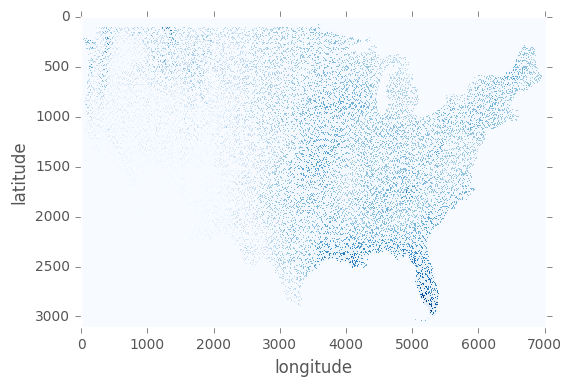

In [28]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='longitude',
                ylabel='latitude',
                axis=[0, 7025, 3105, 0],
                origin='image')

In [29]:
suite.Update(("rain",("raining","june")))

0.048642531289615744

In [ ]:
thinkplot.Contour(suite, contour=False, pcolor=True)
thinkplot.Config(xlabel='longitude',
                ylabel='latitude',
                axis=[0, 7025, 3105, 0],
                origin='image')